In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sklearn
import sklearn.preprocessing

from scipy import sparse

import numpy as np
import pandas as pd
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Input, Embedding
from keras.models import Model
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path

import nltk
nltk.download('stopwords')
import nltk.corpus
import nltk.stem.porter
import nltk.stem.lancaster
import nltk.stem.wordnet

# 1. Load data

In [2]:
csv_df = pd.read_csv('reutersCSV.csv', encoding='iso-8859-1', keep_default_na=False)

In [3]:
csv_df.head()

,pid,fileName,purpose,topic.acq,topic.alum,topic.austdlr,topic.austral,topic.barley,topic.bfr,topic.bop,...,topic.tung,topic.tung.oil,topic.veg.oil,topic.wheat,topic.wool,topic.wpi,topic.yen,topic.zinc,doc.title,doc.text
0,1,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...
1,2,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...
2,3,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...
3,4,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...
4,5,0,train,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...


# 2. Train/test split

In [4]:
csv_df_train = csv_df[csv_df.purpose == 'train']; csv_df_test = csv_df[csv_df.purpose == 'test']

# 3. Preprocess data

In [5]:
csv_df_train.head()

,pid,fileName,purpose,topic.acq,topic.alum,topic.austdlr,topic.austral,topic.barley,topic.bfr,topic.bop,...,topic.tung,topic.tung.oil,topic.veg.oil,topic.wheat,topic.wool,topic.wpi,topic.yen,topic.zinc,doc.title,doc.text
0,1,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...
1,2,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...
2,3,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...
3,4,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...
4,5,0,train,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...


In [6]:
# Let's look what text fields llok like
title, text = csv_df_train.iloc[1][['doc.title', 'doc.text']]
print(title, '\n\n', text)

STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT 

 Standard Oil Co and BP North America Inc said they plan to form a venture to manage the money market borrowing and investment activities of both companies.     BP North America is a subsidiary of British Petroleum Co Plc &lt;BP>, which also owns a 55 pct interest in Standard Oil.     The venture will be called BP/Standard Financial Trading and will be operated by Standard Oil under the oversight of a joint management committee.   Reuter 


### Let's look at labels

In [7]:
label_df_train = csv_df_train.iloc[:,3:-2]

In [8]:
label_df_train.shape, csv_df_train.shape

((14668, 135), (14668, 140))

In [9]:
number_of_documents_per_label = label_df_train.sum()

0 2877


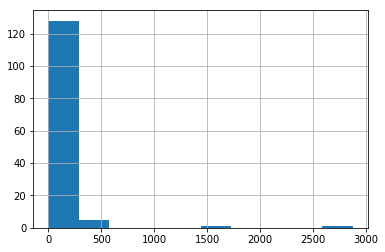

In [10]:
print(number_of_documents_per_label.min(), number_of_documents_per_label.max())
number_of_documents_per_label.hist()

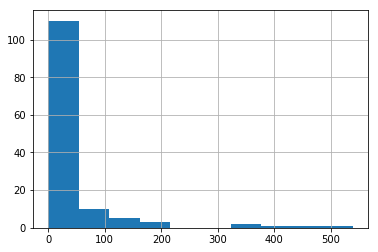

In [11]:
number_of_documents_per_label[number_of_documents_per_label < 1000].hist()

In [12]:
well_represented_topics = number_of_documents_per_label[number_of_documents_per_label > 100].index

In [13]:
well_represented_topics

Index(['topic.acq', 'topic.coffee', 'topic.corn', 'topic.crude', 'topic.dlr',
       'topic.earn', 'topic.gnp', 'topic.grain', 'topic.interest',
       'topic.money.fx', 'topic.money.supply', 'topic.oilseed', 'topic.ship',
       'topic.sugar', 'topic.trade', 'topic.wheat'],
      dtype='object')

### Leave only well represented topics

In [14]:
df_train = csv_df_train[['pid', 'doc.title', 'doc.text'] + well_represented_topics.tolist()]
df_test = csv_df_test[['pid', 'doc.title', 'doc.text'] + well_represented_topics.tolist()]

In [15]:
df_train.iloc[0:1,:]

,pid,doc.title,doc.text,topic.acq,topic.coffee,topic.corn,topic.crude,topic.dlr,topic.earn,topic.gnp,topic.grain,topic.interest,topic.money.fx,topic.money.supply,topic.oilseed,topic.ship,topic.sugar,topic.trade,topic.wheat
0,1,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
df_train.iloc[46:47,:]

,pid,doc.title,doc.text,topic.acq,topic.coffee,topic.corn,topic.crude,topic.dlr,topic.earn,topic.gnp,topic.grain,topic.interest,topic.money.fx,topic.money.supply,topic.oilseed,topic.ship,topic.sugar,topic.trade,topic.wheat
46,47,BRAZIL ANTI-INFLATION PLAN LIMPS TO ANNIVERSARY,"inflation plan, initially hailed at home and a...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### remove rows that contain none of these topics

In [17]:
print('train shape: ', df_train.shape, '; test shape: ', df_test.shape)
df_train.head()

train shape:  (14668, 19) ; test shape:  (6188, 19)


,pid,doc.title,doc.text,topic.acq,topic.coffee,topic.corn,topic.crude,topic.dlr,topic.earn,topic.gnp,topic.grain,topic.interest,topic.money.fx,topic.money.supply,topic.oilseed,topic.ship,topic.sugar,topic.trade,topic.wheat
0,1,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1


In [18]:
df_train = df_train[df_train.iloc[:,3:].any(axis=1)]
df_test = df_test[df_test.iloc[:,3:].any(axis=1)]

In [19]:
print('train shape: ', df_train.shape, '; test shape: ', df_test.shape)
df_train.head()

train shape:  (6957, 19) ; test shape:  (2679, 19)


,pid,doc.title,doc.text,topic.acq,topic.coffee,topic.corn,topic.crude,topic.dlr,topic.earn,topic.gnp,topic.grain,topic.interest,topic.money.fx,topic.money.supply,topic.oilseed,topic.ship,topic.sugar,topic.trade,topic.wheat
4,5,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
5,6,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,Argentine grain board figures show crop regist...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
8,9,CHAMPION PRODUCTS &lt;CH> APPROVES STOCK SPLIT,Champion Products Inc said its board of direct...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,10,COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...,Computer Terminal Systems Inc said it has comp...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,11,COBANCO INC &lt;CBCO> YEAR NET,"Shr 34 cts vs 1.19 dlrs Net 807,000 vs 2,8...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


# 4. Preprocess text

In [20]:
def lower_case(string):
    return string.lower()

def fix_lt(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'&lt;', '<', string)

def remove_reuter(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'reuter$', '', string)

def replace_non_alphanumeric_with_space(string):
    # replace punctuation and different whitespace with space character
    return re.sub(r'[^a-z0-9 ]', ' ', string)

def strip_punctuation(string):
    # remove punctuation
    return re.sub(r'[^a-z0-9\s]', ' ', string)

def remove_stop_words(string, stop_words):
    return ' '.join([ word for word in re.split(' ', string) if not word in stop_words ])

def replace_numeric_with_literal(string):
    return re.sub(r'([0-9]+ ?)+', '<num> ', string)

def compact_whitespace(string):
    return re.sub(r'\s+', ' ', string)

def stem(string, stemmer):
    return ' '.join([ 
        stemmer.stem(word) if hasattr(stemmer, 'stem') else stemmer.lemmatize(word)
        for word in re.split(' ', string) if not word in stop_words 
    ])

In [21]:
stop_words = nltk.corpus.stopwords.words('english')

stemmer = nltk.stem.lancaster.LancasterStemmer()
# stemmer = PorterStemmer()

In [22]:
def pre_process(string):
    s = lower_case(string)
    s = fix_lt(s)
    s = remove_reuter(s)
    s = strip_punctuation(s)
    s = remove_stop_words(s, stop_words)
    s = compact_whitespace(s)
    s = replace_numeric_with_literal(s)
    #s = stem(s, stemmer)
    return s.strip()

In [23]:
example = 'Autobahn-FX 2, &lt;RMS> are now being actively developed; GDS decom will be finished by 2055 or 2056'
pre_process(example)

'autobahn fx <num> rms actively developed gds decom finished <num>'

In [24]:
def pre_process_text_fields(df):
    df['text'] = df['doc.title'].map(lambda x: pre_process(x)) + ' ' + df['doc.text'].map(lambda x: pre_process(x))
    return df.drop(labels=['doc.title','doc.text'], axis=1)

In [25]:
df_train = pre_process_text_fields(df_train)
df_test = pre_process_text_fields(df_test)

In [26]:
df_train.iloc[0:1,:]

,pid,topic.acq,topic.coffee,topic.corn,topic.crude,topic.dlr,topic.earn,topic.gnp,topic.grain,topic.interest,topic.money.fx,topic.money.supply,topic.oilseed,topic.ship,topic.sugar,topic.trade,topic.wheat,text
4,5,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,national average prices farmer owned reserve u...


In [27]:
df_train.shape, df_test.shape

((6957, 18), (2679, 18))

# 6. Vectorize labels

In [28]:
y_train = df_train.iloc[:,1:-1].values
y_test = df_test.iloc[:,1:-1].values

In [29]:
y_train.shape, y_test.shape

((6957, 16), (2679, 16))

# 5. Prepare embeddings

### read glove embeddings

Download from https://nlp.stanford.edu/projects/glove/ archive glove.6B.zip

In [30]:
with open('glove.6B.50d.txt', 'r') as f: glove_text = f.read()

In [31]:
glove_lines = glove_text.split('\n')

In [32]:
print('\n'.join(glove_lines[:5]))

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581
, 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 -0.23938 0.13001 -0.063734 -0.39575 -0.48162 0.23291 0.090201 -0.13324 0.078639 -0.41634 -0.15428 0.10068 0.48891 0.31226 -0.1252 -0.037512 -1.5179 0.12612 -0.02442 -0.042961 -0.28351 3.5416 -0.11956 -0.014533 -0.1499 0.21864 -0.33412 -0.13872 0.31806 0.70358 0.44858 -0.080262 0.63003 0.32111 -0.46765 0.22786 0.36034 -0.37818 -0.56657 0.044691 0.30392
. 0.15164 0.30177 -0.16763 0.17684 0.31719 0.33973 -0.43478 -0.31086 -0.44999 -0.29486 0.16608 0.11963 -0.41328 -0.42353

In [33]:
glove_lines.pop()

''

In [34]:
def _get_word(line): return line.split()[0]
def _get_emb(line): return np.array(list(map(float, line.split()[1:])), dtype=np.float)
glove_word2emb = {_get_word(line): _get_emb(line) for line in glove_lines}

In [35]:
def word_to_embedding(word):
    if '<num>' in word: return glove_word2emb['0']
    if word in glove_word2emb: return glove_word2emb[word]
    return np.ones(glove_word2emb['0'].shape) * -1

### word to index

In [36]:
train_words = list(map(lambda x: x.split(), df_train.text.tolist()))
flatten = lambda l: [item for sublist in l for item in sublist]
train_words = list(set(flatten(train_words)))

In [37]:
glove_words = list(glove_word2emb.keys())

In [38]:
train_words_not_in_glove = sorted(list(set(train_words).difference(set(glove_words))))
train_words_in_glove = sorted(list(set(train_words).difference(set(train_words_not_in_glove))))
train_words_indices = {word: i+1 for (i,word) in enumerate(train_words_in_glove)}
for word in train_words_not_in_glove:
    if '<num>' in word: train_words_indices[word] = len(train_words_in_glove) + 1
    else: train_words_indices[word] = len(train_words_in_glove) + 2

In [39]:
def word_to_index(word):
    if word in train_words_indices: return train_words_indices[word]
    else: return max(train_words_indices.values())

### text to sentences

In [40]:
sentences = df_train.text.tolist()

### sentences as indices

In [41]:
sentence_max_len = max(map(len, sentences))
sentences_as_indices = np.zeros((len(sentences), sentence_max_len))

In [42]:
for i in range(len(sentences)):
    for (j, word) in enumerate(sentences[i].split()):
        sentences_as_indices[i, j] = word_to_index(word)

### embedding matrix

In [43]:
vocab_len = (len(train_words_in_glove) +2) + 1 # +1 required for keras embeddings
emb_dim = glove_word2emb['0'].shape[0]
embedding_matrix = np.zeros((vocab_len, emb_dim))

for (word, index) in train_words_indices.items():
    embedding_matrix[index, :] = word_to_embedding(word)

# 7. Train a model

### Try double LSTM with word2vec embeddings

Architecture
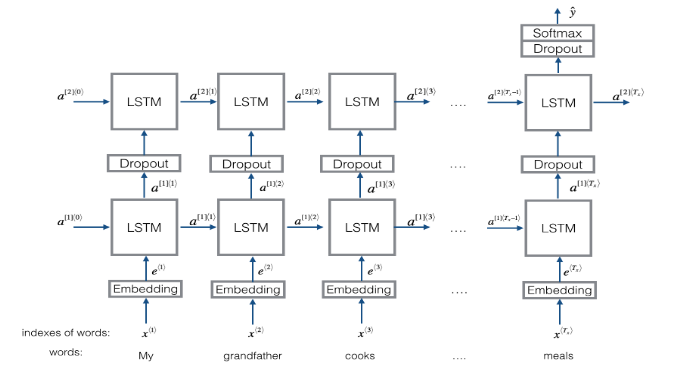

In [44]:
num_labels = y_train.shape[1]

In [45]:
def prebuild_embedding_layer(embedding_matrix):
    vocab_len, emb_dim = embedding_matrix.shape
    embedding_layer = Embedding(input_dim=vocab_len, output_dim=emb_dim, trainable=False)
    embedding_layer.build((None,)) # that's need to be done to be able to set weight
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

In [46]:
inputs = Input(shape=(sentence_max_len,))
embeddings = prebuild_embedding_layer(embedding_matrix)(inputs)
X = LSTM(128, return_sequences=True)(embeddings)
X = Dropout(0.5)(X)
X = LSTM(128, return_sequences=False)(X)
X = Dropout(0.5)(X)
X = Dense(units=num_labels)(X)
X = Activation('sigmoid')(X)

In [47]:
model = Model(inputs=inputs, outputs=X)

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6439)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 6439, 50)          980650    
_________________________________________________________________
lstm_1 (LSTM)                (None, 6439, 128)         91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6439, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
__________

In [49]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
history = model.fit(sentences_as_indices, y_train,
                    batch_size=15,
                    epochs=30,
                    verbose=1,
                    validation_split=0.1)

Train on 6261 samples, validate on 696 samples
Epoch 1/30
6261/6261 [==============================] - 4669s 746ms/step - loss: 0.2369 - acc: 0.9165 - val_loss: 0.2322 - val_acc: 0.9261
Epoch 2/30
6261/6261 [==============================] - 4699s 751ms/step - loss: 0.2086 - acc: 0.9269 - val_loss: 0.2365 - val_acc: 0.9261
Epoch 3/30
6261/6261 [==============================] - 4697s 750ms/step - loss: 0.2071 - acc: 0.9274 - val_loss: 0.2369 - val_acc: 0.9262
Epoch 4/30
6261/6261 [==============================] - 4691s 749ms/step - loss: 0.2061 - acc: 0.9285 - val_loss: 0.2375 - val_acc: 0.9262
Epoch 5/30
6261/6261 [==============================] - 4700s 751ms/step - loss: 0.2051 - acc: 0.9288 - val_loss: 0.2310 - val_acc: 0.9262
Epoch 6/30
6261/6261 [==============================] - 4691s 749ms/step - loss: 0.2048 - acc: 0.9288 - val_loss: 0.2329 - val_acc: 0.9262
Epoch 7/30
6261/6261 [==============================] - 4720s 754ms/step - loss: 0.2044 - acc: 0.9286 - val_loss: 0.233

KeyboardInterrupt: 

#### evaluate

In [51]:
sentences_test = df_test.text.tolist()

In [53]:
sentences_as_indices_test = np.zeros((len(sentences_test), sentence_max_len))

In [54]:
score = model.evaluate(sentences_as_indices_test, y_test, batch_size=25, verbose=1)

2679/2679 [==============================] - 420s 157ms/step


In [56]:
print('Test accuracy:', score[1])

Test accuracy: 0.9296612610964687
